In [109]:
# packages
import pandas as pd
import pyarrow.dataset as ds
from datasets import Dataset
import pyarrow as pa
from datasets import *
from transformers import *
from tokenizers import *
import os
import json
import sys
from tokenizers.processors import BertProcessing
import numpy as np

In [111]:
version = 1
MAX_LENGTH = 1024

if version == 1:
    data_dir = '/scratch/xin/mvdsc_task/mvdsc_v1'
    bert_dir = '/scratch/xin/bert_source_v1'
    tokenizer_path = 'BPE_tokenizer'
    out_dir = 'task_mvdsc_v1/'




In [112]:
# load data
# 
# /scratch/xin/bert_source/mvdsc/tokenized_mvdsc_valid.pkl
# /scratch/xin/bert_source/mvdsc/tokenized_mvdsc_test.pkl
def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'label': []}
    for i in range(len(raw_df['code'])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split('\n')
        code = ' '.join(code)
        df['text'].append(code)
        df['label'].append(raw_df['bug'][i])
    df = pd.DataFrame(df)
    return df
    ### convert to Huggingface dataset
#     return Dataset(pa.Table.from_pandas(df))

# train_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_train.pkl')
# valid_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_valid.pkl')
# test_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_test.pkl')
# /scratch/xin/mvdsc_task/mvdsc_v2/tokenized_mvdsc_

train_data = get_data(os.path.join(data_dir, 'tokenized_mvdsc_train.pkl'))
valid_data = get_data(os.path.join(data_dir, 'tokenized_mvdsc_valid.pkl'))
test_data = get_data(os.path.join(data_dir,'tokenized_mvdsc_test.pkl'))

print(train_data['text'][0])
print(test_data['text'][55])


VOID NONE LPAREN RPAREN LBRACE CHAR TIMES TIMESxID SEMI CHAR CHARxIDxTIMES LBRACKET 6 5 6 RBRACKET SEMI TIMESxID EQUALS CHARxIDxTIMES SEMI MEMSET LPAREN TIMESxID COMMA QUOTATION 3 COMMA 3 1 6 RPAREN SEMI TIMESxID LBRACKET 5 7 1 RBRACKET EQUALS QUOTATION 4 SEMI TIMESxID LBRACKET 4 4 9 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 3 5 7 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 8 1 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 4 0 3 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 1 4 2 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 3 6 5 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 6 9 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 9 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 1 9 7 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 3 9 6 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 4 7 7 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 5 1 4 RBRACKET EQUALS QUOTATION 1 SEMI TIMESxID LBRACKET 2 2 2 RBRACKET EQUALS QUOTATION 1 SEMI TIMESx

In [113]:
# train_data.shape
print(len(train_data))
# print(train_data.head(10))
# print(train_extracted_data.head(10))
# train_data = train_data[:100]
# print(train_extracted_data[7])

37985


In [114]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts

,label
0,26569
1,11416


In [115]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

[0, 1]

In [116]:
train_texts = train_data['text'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

In [117]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
print(min(text_lengths))
print(max(text_lengths))
print(statistics.mean(text_lengths))
print(statistics.stdev(text_lengths))

0
1253
258.9496643411873
277.6756136450945


/home/xzhou29/miniconda/envs/bert/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'counts')

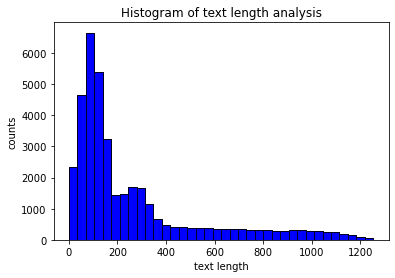

In [56]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')

In [57]:


sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

1216

In [58]:
# from transformers import DistilBertTokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
# load pre-trained BERTSource model
# load the model checkpoint
# model_path_ = '{}/pretrained-cbert'.format(bert_dir)
# bertsource_model = BertForMaskedLM.from_pretrained(os.path.join(model_path, "checkpoint-43000"))

# load the tokenizer
print('-'*50)
# tokenizer = BertTokenizerFast.from_pretrained(bert_dir)
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_path, max_len=max_length)
print('-'*50)

# print('Original Text: ', texts[0], '\n')
# print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
# print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

In [59]:
# text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]

train_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in train_texts]
valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in valid_texts]
test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_special_tokens_mask=True) for t in test_texts]

In [60]:
# text_ids[0]['input_ids']
# text_ids[0]['token_type_ids']
# text_ids[0]['attention_mask']
# text_ids[0]['special_tokens_mask']
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]
# text_ids[0]

In [61]:
# text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
# print(min(text_ids_lengths))
# print(max(text_ids_lengths))

In [62]:
train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# att_masks[0]


In [63]:

from sklearn.model_selection import train_test_split

# train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=111, test_size=0.2)
# train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

# test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=111, test_size=0.5)
# test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)
train_x, train_m, train_y = train_text_ids, train_att_masks, train_labels
val_x, val_m, val_y = valid_text_ids, valid_att_masks, valid_labels
test_x, test_m, test_y = test_text_ids, test_att_masks, test_labels

In [64]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)


print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([37985, 1024])
torch.Size([8494, 1024])
torch.Size([8494, 1024])
torch.Size([37985])
torch.Size([8494])
torch.Size([8494])
torch.Size([37985, 1024])
torch.Size([8494, 1024])
torch.Size([8494, 1024])


In [65]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# 6 for gtx3080ti
# 16 for redas-lab2
batch_size = 6


train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = list(range(len(train_data)))
# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



# train_loader_extracted = torch.utils.data.DataLoader(train_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=train_sampler)


# valid_loader_extracted = torch.utils.data.DataLoader(valid_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=val_sampler)


In [121]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys

class DotAttention(nn.Module):

    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.attn_vector = nn.Parameter(
            torch.Tensor(1, hidden_size), requires_grad=True)

        init.xavier_uniform(self.attn_vector.data)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths=None):
        batch_size, max_len = inputs.size()[:2]

        '''
        print("INPUTS", inputs.size())
        print("ATTN", self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, hidden_size, 1)
                            .transpose(2, 1)
                            .repeat(batch_size, 1, 1).size())'''
        # apply attention layer
        weights = torch.bmm(inputs,
                            self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, 1, hidden_size)
                            .transpose(2, 1) # (1, hidden_size, 1)
                            .repeat(batch_size, 1, 1)) # (batch_size, hidden_size, 1))

        attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))

        # create mask based on the sentence lengths
        #idxes = torch.arange(0, max_len, out=torch.LongTensor(max_len)).unsqueeze(0).cuda()  # some day, you'll be able to directly do this on cuda
        #mask = Variable((idxes < lengths.data.unsqueeze(1)).float())

        # apply mask and renormalize attention scores (weights)
        #masked = attn_weights * mask
        _sums = attn_energies.sum(-1).unsqueeze(1).expand_as(attn_energies)  # sums per row
        attn_weights = attn_energies / _sums

        # print('attn_weights: ', attn_weights.shape)
        # apply attention weights

        weighted = torch.mul(inputs, attn_weights.unsqueeze(-1).expand_as(inputs))

        # print('weighted: ', weighted.shape)

        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()
        
        if len(representations.shape) == 1:
            representations = representations.reshape(1, representations.shape[-1])
        # print('representations: ', representations.shape)

        return representations, attn_weights
    
    
class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
        self.model = BertForMaskedLM.from_pretrained(checkpoint)
        #Load Model with given checkpoint and extract its body
        # self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.2)
        
        self.features = nn.Linear(56, 56)
        self.softmax = nn.Softmax()
        
        self.classifier = nn.Linear(768 * 4, num_labels) # load and initialize weights
        self.out = nn.Softmax()
        self.attn = DotAttention(hidden_size = 768)
    
    def forward_single(self, input_ids, attention_mask, labels, ex):
        outputs = self.model.bert(input_ids, attention_mask=attention_mask)[0]
#         print(outputs, outputs.shape)
        pooler_output = outputs[:, 0, :]
#         print(pooler_output )
        # max + last + attention START
        last =  outputs[:,-1] 
        attn, attention_weights = self.attn.forward(outputs)
        max_ , _ = torch.max(outputs, dim=1)
        concatenated = torch.cat([last, max_, attn, pooler_output], dim=1)
        # Add custom layers
        sequence_output = self.dropout(concatenated) #outputs[0]=last hidden state
        logits = self.classifier(sequence_output) # calculate losses
        #return logits, attention_weights
        #loss = None
        #if labels is not None:
            #loss_fct = nn.CrossEntropyLoss()
            #loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return logits, attention_weights
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, ex=None, max_len=MAX_LENGTH, opt='mean'):
        #Extract outputs from the body
        final_logits = None
        final_attention_weights = None
        # pick the most suspicous one for final decision
        for i in range(0, max_len, 512):
            logits, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], labels, ex)
            if final_logits is None:
                final_logits = logits
                final_attention_weights = attention_weights
            else:
                final_logits = torch.cat([final_logits,  logits], dim=1)
                final_attention_weights = torch.cat([final_attention_weights,  attention_weights], dim=1)
            #loss, logits = output
        
        final_logits = final_logits.reshape(final_logits.shape[0], max_len//512, 2)
        
        if opt == 'mean':
            # mean 
            final_logits = torch.mean(final_logits, dim=(1))
        else:
            # max
            final_logits = torch.amax(final_logits, dim=(1))
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(final_logits.view(-1, self.num_labels), labels.view(-1))
            
        final_logits = self.softmax(final_logits)
        return (loss, final_logits), final_attention_weights


        #return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [122]:
# from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# num_labels = len(set(labels))
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
#                                                             output_attentions=False, output_hidden_states=False)
# model_path = '{}/pretrained-bert'.format(bert_dir)
model_path = os.path.join(bert_dir, "checkpoint-60000")
model = BERTSourceBinaryClassification(checkpoint=model_path, num_labels=2)


/tmp/ipykernel_30868/4102100300.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.attn_vector.data)


In [123]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print('Number of trainable parameters:', count_parameters(model), '\n', model)

In [124]:
# [n for n, p in model.named_parameters()]

In [125]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [126]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)
model = model.cuda()

Let's use 4 GPUs!


In [127]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 20
max_step_saves = 5
save_step_at = 500

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [128]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [129]:
import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [130]:
import pickle
import os

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [131]:
# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)

In [132]:
print('number of iterations: ', len(train_dataloader))

number of iterations:  2375


In [134]:
from tqdm import tqdm
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)
current_step = 0
saved_steps = []
if num_mb_val == 0:
    num_mb_val = 1

# print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
print('num_epochs: ', num_epochs)

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
    for k, (mb_x, mb_m, mb_y) in tqdm(enumerate(train_dataloader)):
        #mb_x, mb_m, mb_y = data1
        # 56 features
        #ex, ey, e_index = data2
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
        mb_y = mb_y.cuda()
        #ex = ex.cuda()
        
        outputs, _ = model(mb_x, attention_mask=mb_m, labels=mb_y)
        # results = model(mb_x, attention_mask=mb_m, labels=mb_y)
        
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)

        if multi_gpu > 1:
            loss = loss.sum()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        current_step += 1
        train_loss += loss.data / num_mb_train
        
        if current_step % save_step_at == 0:
            saved_steps.append(current_step)
            out_dir_model = './{}/classification_model_{}'.format(out_dir, saved_steps[-1])
            print('saved as: ', out_dir_model)
            if len(saved_steps) > max_step_saves:
                delete_dir = './{}/classification_model_{}'.format(out_dir, saved_steps[-(max_step_saves+1)])
                os.system('rm -r {}'.format(delete_dir))
            save_model(model, train_losses, val_losses, out_dir_model)
            
            
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    with torch.no_grad():
        model.eval()
        
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.cuda()
            mb_m = mb_m.cuda()
            mb_y = mb_y.cuda()

            outputs, _ = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
            
            if multi_gpu > 1:
                loss = loss.sum()
            #loss = model_loss(outputs[1], mb_y)
            
            val_loss += loss.data / num_mb_val
            
        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        # save the best
        print('val_losses: ', val_losses, float(val_loss.cpu()))
        if val_losses and float(val_loss.cpu()) < min(val_losses):
            print('the best model updated')
            print('saved as: ', out_dir_model)
            out_dir_model = './{}/classification_model_best'.format(out_dir)
            save_model(model, train_losses, val_losses, out_dir_model)
        val_losses.append(float(val_loss.cpu()))
        
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')
    if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
        break

num_epochs:  20


0it [00:00, ?it/s]

torch.Size([16, 1024])


SystemExit: 0

/home/xzhou29/miniconda/envs/bert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [107]:
# model_to_save = model.module if hasattr(model, 'module') else model
# model_to_save.save_pretrained(out_dir)
# tokenizer.save_pretrained(out_dir)


# out_dir = './model'

# model = DistilBertForSequenceClassification.from_pretrained(out_dir)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# with open(out_dir + '/train_losses.pkl', 'rb') as f:
#     train_losses = pickle.load(f)
    
# with open(out_dir + '/val_losses.pkl', 'rb') as f:
#     val_losses = pickle.load(f)

In [108]:
out_dir_model = '{}/classification_model_best'.format(out_dir)
PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(out_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(out_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

FileNotFoundError: [Errno 2] No such file or directory: 'task_mvdsc_v3//classification_model_best/BERTSourceBinaryClassification.pt'

In [99]:
from tqdm import tqdm
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# print(test_x[0])

print(len([e for e in test_text_dict[4]['input_ids'] if e != 0]))

print(len((test_texts[4]).split(' ')))

print(len((test_texts[4]).split(' ')))

271
269
269


In [100]:

outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, mb_m) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
#         output, _ = model(mb_x)
        output, attention_weights = model(mb_x, attention_mask=mb_m)
#         print(output)
#         print(attention_weights[4])
#         sys.exit(0)
        outputs.append(output[1].to('cpu'))
        
outputs = torch.cat(outputs)

num of iterations:  531


0it [00:00, ?it/s]/tmp/ipykernel_30868/1631530735.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
531it [12:06,  1.37s/it]


In [101]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

from sklearn.metrics import precision_recall_fscore_support

# precision, recall, f1, support
print(precision_recall_fscore_support(true_values, predicted_values, average='binary'))


In [102]:
print(true_values[:100])

print(predicted_values[:100])

[1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0
 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0
 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0]
[1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0
 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0]


In [103]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9531433953378856


In [104]:
from sklearn.metrics import classification_report

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      6169
           1       0.95      0.88      0.91      2325

    accuracy                           0.95      8494
   macro avg       0.95      0.93      0.94      8494
weighted avg       0.95      0.95      0.95      8494



In [105]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6058  111]
 [ 287 2038]]
Normalized confusion matrix
[[0.98 0.02]
 [0.12 0.88]]


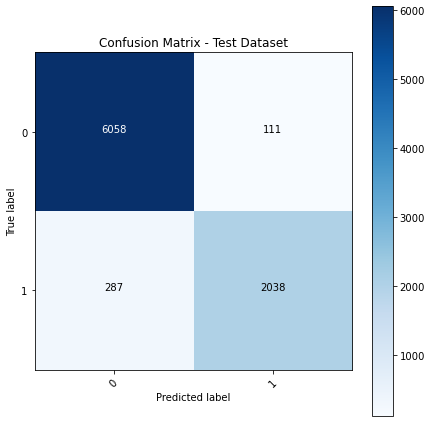

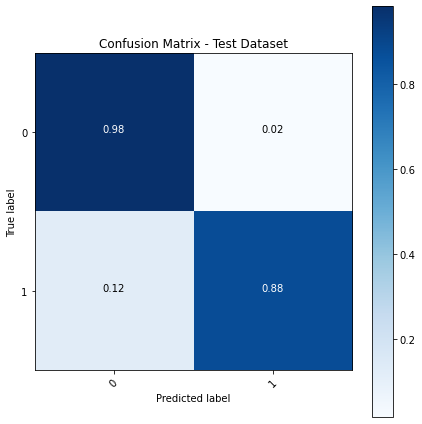

In [106]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)



np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

